[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HSF-reco-and-software-triggers/Tracking-ML-Exa.TrkX/blob/master/Examples/TrackML_Quickstart/DM_colab_quickstart.ipynb)

# QuirkTacking 

# Import libraries

In [1]:
import sys, os
sys.path.append("../../")
from Scripts import train_metric_learning, run_metric_learning_inference, train_gnn, run_gnn_inference, build_track_candidates, evaluate_candidates
from Scripts.utils.convenience_utils import get_example_data, plot_true_graph, get_training_metrics, plot_training_metrics, plot_neighbor_performance, plot_predicted_graph, plot_track_lengths, plot_edge_performance, plot_graph_sizes
import yaml

import warnings
warnings.filterwarnings("ignore")
CONFIG = 'pipeline_config.yaml'

/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

Loading BokehJS ...

## TrackML Dataset

The TrackML dataset contains simulated indepedent proton-proton collision events, each generating hundreds of particles, each of which hits cells and layers of the detector layers multiple times. The detector records the spatial coordinates and other auxillary information of these hits which, if properly connected, form tracks associated with the parent particle and the collision event from which it originates. The challenge and goal of this project is to associate each and every hit to one single track with optimal purity and efficiency, whose precise definition will be given later.

Each entry in the particles data frame contains a unique identifier of the particle (particle_id), its charge (q), its initial position or vertex $(v_x, v_y, v_z)$, its initial momentum in GeV/c $(p_x, p_y, p_z)$ and its associated number of detector hits. 

Many particles do not leave behind any detector hits and obviously cannot be associated to any track. This is called "detector inefficiency". They are among "uninterested particles" and will be mostly filtered out by a simple momentum cut.

### Training data
Let us take a look at the data before training. In this example pipeline, we have preprocessed the TrackML data into a more convenient form. We calculated directional information and summary statistics from the charge deposited in each spacepoints, and append them to its cyclidrical coordinates. Let us load an example data file and inspect the content.

In [18]:
with open(CONFIG, 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)

In [19]:
example_data_df, example_data_pyg = get_example_data(configs)
example_data_df.head()

,0,1,2
0,0.062,0.644834,0.0492
1,0.101,0.641032,0.0800
2,0.177,0.633742,0.1400
3,0.245,0.627006,0.1940
4,0.598,0.592054,0.4756


### Visualize tracks

A "true track" is defined as a set of sequential hits, all left by the same particle. Therefore a true edge is the edge formed by two sequential hits. Let's visualize a random set of 200 true tracks:

In [20]:
plot_true_graph(example_data_pyg, num_tracks=200)

# 1. Train Metric Learning

## Train metric learning model

Finally we come to model training. By default, we train the MLP for 30 epochs, which takes approximately 15 minutes on an NVidia V100. Feel free to adjust the epoch number in pipeline_config.yml

In [22]:
metric_learning_trainer, metric_learning_model = train_metric_learning(CONFIG)

-------------------- Step 1: Running metric learning training --------------------
----------------------------- a) Initialising model -----------------------------
------------------------------ b) Running training ------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 3.2 M 
---------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.694    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s, loss=0.008, v_num=1]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 79/79 [00:23<00:00,  3.40it/s, loss=0.008, v_num=1]
-------------------------------- c) Saving model --------------------------------


## Plot training metrics

We can examine how the training went. This is stored in a simple dataframe:

In [ ]:
embedding_metrics = get_training_metrics(metric_learning_trainer)
embedding_metrics.head()

,epoch,train_loss,val_loss,eff,pur,current_lr
0,0,0.009722,0.004960,0.988072,0.024078,0.000125
1,1,0.008682,0.004604,0.932385,0.062733,0.000250
2,2,0.008670,0.004355,0.956021,0.104069,0.000375
3,3,0.008442,0.004381,0.967555,0.094358,0.000350
4,4,0.008247,0.004166,0.972913,0.149198,0.000625


In [ ]:
plot_training_metrics(embedding_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [ ]:
plot_neighbor_performance(metric_learning_model)

cuda
Data(x=[863, 3], pid=[863], event_file='datasets/feature_store/QuirkTracking_sample/1035', hid=[863], pt=[863], modulewise_true_edges=[2, 753], layerwise_true_edges=[2, 753], signal_true_edges=[2, 753])


## Plot example truth and predicted graphs

In [ ]:
plot_predicted_graph(metric_learning_model)

Data(x=[863, 3], pid=[863], event_file='datasets/feature_store/QuirkTracking_sample/1035', hid=[863], pt=[863], modulewise_true_edges=[2, 753], layerwise_true_edges=[2, 753], signal_true_edges=[2, 753])
tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 14, 12, 10, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 10, 14, 14, 14, 14, 14, 14, 12, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 14,
        14, 14, 14, 14, 14, 14, 14, 14,  8, 12, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 12, 14, 14, 14, 12, 10, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14], device='cuda:0')
tensor([ 201.,  202.,  223.,  578.,  580.,  601.,  605.,  641.,  642.,  748.,
         768.,  772.,  773.,  778.,  782.,  783.,  801.,  911.,  943.,  973.,
         974.,  979., 1032., 1059., 1063., 1065., 1066., 1067., 1069., 1070.,
        1168., 1170., 1191., 1195., 1199., 1279.,

## Track lengths

In [ ]:
plot_track_lengths(metric_learning_model)

100%|██████████| 71/71 [00:12<00:00,  5.66it/s]


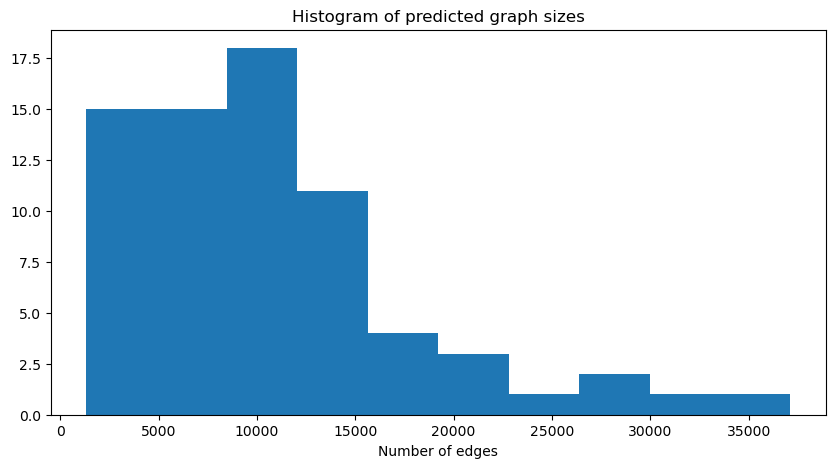

In [ ]:
plot_graph_sizes(metric_learning_model)

# 2. Construct graphs from metric learning inference

This step performs model inference on the entire input datasets (train, validation and test), to obtain input graphs to the graph neural network. Optionally, we also clear the directory.

In [23]:
graph_builder = run_metric_learning_inference(CONFIG)

------------- Step 2: Constructing graphs from metric learning model -------------
---------------------------- a) Loading trained model ----------------------------
----------------------------- b) Running inferencing -----------------------------
Training finished, running inference to build graphs...


100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


# 3. Train graph neural networks

We have a set of graphs constructed. We now train a GNN to classify edges as either "true" (belonging to the same track) or "false" (not belonging to the same track).

In [2]:
gnn_trainer, gnn_model = train_gnn(CONFIG)

-------------------------  Step 3: Running GNN training  -------------------------
----------------------------- a) Initialising model -----------------------------
------------------------------ b) Running training ------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 34.0 K
1 | edge_encoder           | Sequential | 66.4 K
2 | edge_network           | Sequential | 82.8 K
3 | node_network           | Sequential | 82.8 K
4 | output_edge_classifier | Sequential | 83.2 K
------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.397     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 79/79 [00:09<00:00,  8.36it/s, loss=0.00618, v_num=2]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 79/79 [00:09<00:00,  8.29it/s, loss=0.00618, v_num=2]
-------------------------------- c) Saving model --------------------------------


## Plot training metrics

In [3]:
gnn_metrics = get_training_metrics(gnn_trainer)
gnn_metrics.head()

KeyError: "['edge_true_positive', 'edge_postive'] not in index"

In [36]:
plot_training_metrics(gnn_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [37]:
plot_edge_performance(gnn_model)

Epoch 2:   3%|▎         | 2/79 [23:52<15:19:09, 716.23s/it, loss=0.0111, v_num=0]


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/connection.py", line 182, in close
    reader_close()
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/connection.py", line 182, in close
    reader_close()
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/connection.py", line 182, in close
 

Epoch 5:   0%|          | 0/79 [10:59<?, ?it/s, loss=0.00199, v_num=2]


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multip

Epoch 6:  65%|██████▍   | 51/79 [09:28<05:12, 11.15s/it, loss=0.000621, v_num=2]


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/connection.py", line 182, in close
    self._close()
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multiprocessing/connection.py", line 366, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/multip

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# Step 4: GNN inference 

In [ ]:
run_gnn_inference(CONFIG)

INFO:--------------------- Step 4: Scoring graph edges using GNN  ---------------------
INFO:---------------------------- a) Loading trained model ----------------------------
INFO:----------------------------- b) Running inferencing -----------------------------


Training finished, running inference to filter graphs...
Building train


100%|██████████| 80/80 [00:01<00:00, 78.56it/s]


Building val


100%|██████████| 10/10 [00:00<00:00, 21.31it/s]


Building test


100%|██████████| 10/10 [00:00<00:00, 24.97it/s]


# Step 5: Build track candidates from GNN

In [ ]:
build_track_candidates(CONFIG)

INFO:-----------  Step 5: Building track candidates from the scored graph  -----------
INFO:---------------------------- a) Loading scored graphs ----------------------------
INFO:---------------------------- b) Labelling graph nodes ----------------------------
100%|██████████| 129/129 [00:02<00:00, 46.90it/s]


# Step 6: Evaluate track candidates

We can control the matching style in the pipeline config file. The following all require at least a majority of hits to match in each scheme (i.e. matching fraction = 50%).
A discussion of each matching style and some worked examples can be found in the [Documentation](https://hsf-reco-and-software-triggers.github.io/Tracking-ML-Exa.TrkX/performance/matching_definitions/).

ATLAS style matching is the default.

INFO:------------ Step 6: Evaluating the track reconstruction performance ------------
INFO:--------------------------- a) Loading labelled graphs ---------------------------
100%|██████████| 100/100 [00:02<00:00, 43.54it/s]
INFO:--------------------- b) Calculating the performance metrics ---------------------
INFO:Number of reconstructed particles: 109213
INFO:Number of particles: 114164
INFO:Number of matched tracks: 137346
INFO:Number of tracks: 137881
INFO:Number of duplicate reconstructed particles: 28116
INFO:Efficiency: 0.957
INFO:Fake rate: 0.004
INFO:Duplication rate: 0.257
INFO:------------------------------ c) Plotting results ------------------------------


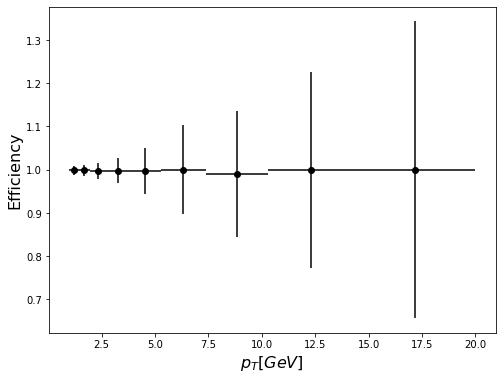

In [ ]:
evaluated_events, reconstructed_particles, particles, matched_tracks, tracks = evaluate_candidates(CONFIG)